Clustering Lesson

3ème leçon au jour du 23 février 2023

Steps

    Select variables you want to cluster: df = df[["col1", "col2"]]
    Convert to array & dtype float: np_array = df.values.astype("float32", copy = False)
    Scale to standard normal:

        scaler = StandardScaler().fit(np_array) np_array = scaler.transform(np_array)

    Create DBSCAN object and fit: dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)
    Extract labels: labels = dbsc.labels_
    Add labels back to original dataframe:

        df['labels'] = labels

    Explore:

        df.labels.value_counts() sns.scatterplot(df.col1, df.col2, hue=df.labels)



In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler


In [2]:
from env import host, username, password

def get_db_url(database, host=host, username=username, password=password):
    return f'mysql+pymysql://{username}:{password}@{host}/{database}'


In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# Cluster on all or a selected subset of features
grocery_milk_fresh = df[["Grocery", "Milk", "Fresh"]]

grocery_milk_fresh.head(2)


,Grocery,Milk,Fresh
customer_id,,,
0,7561,9656,12669
1,9568,9810,7057


Step #3

In [5]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(grocery_milk_fresh)

# Use the scaler
grocery_milk_fresh = scaler.transform(grocery_milk_fresh)
grocery_milk_fresh


array([[0.08146416, 0.13072723, 0.11294004],
       [0.10309667, 0.13282409, 0.06289903],
       [0.08278992, 0.11918086, 0.05662161],
       ...,
       [0.32594285, 0.21013575, 0.1295431 ],
       [0.02402535, 0.02622442, 0.091727  ],
       [0.02702178, 0.02237109, 0.02482434]])

In [6]:
# Now, let's add the scaled value columns back onto the dataframe

columns = ["Grocery", "Milk", "Fresh"]
scaled_columns = ["Scaled_" + column for column in columns]


# Save a copy of the original dataframe

original_df = df.copy()


# Create a dataframe containing the scaled values

scaled_df = pd.DataFrame(grocery_milk_fresh, columns=scaled_columns)


In [7]:
# Merge the scaled and non-scaled values into one dataframe

df = df.merge(scaled_df, on = df.index)
df = df.drop(columns = ['key_0'])
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626


Step #4

```sklearn.cluster.DBSCAN```

In [8]:
# Make the object
# eps = distance

dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(grocery_milk_fresh)



DBSCAN(eps=0.1, min_samples=20)

Step #5

In [9]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
df['labels'] = dbsc.labels_


In [10]:
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers

df.labels.value_counts()

 0    409
-1     31
Name: labels, dtype: int64

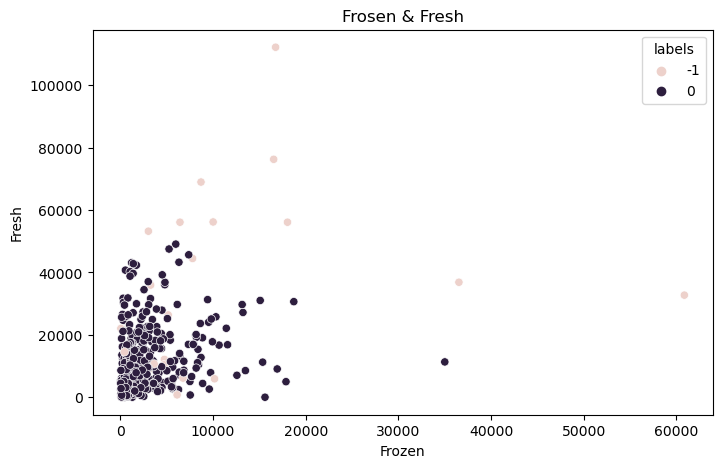

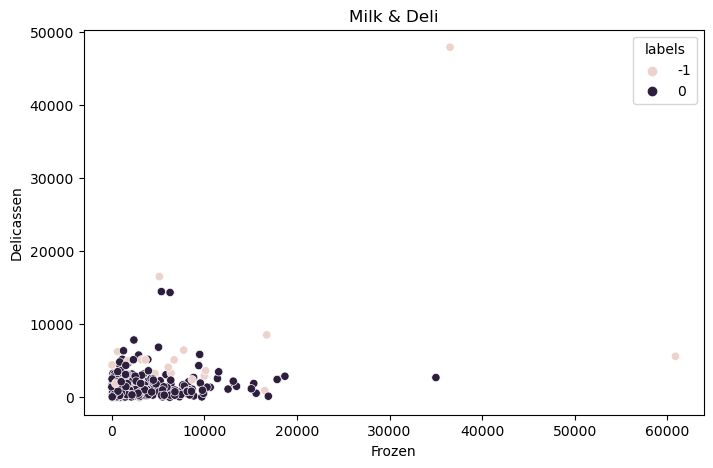

In [23]:
# plotting

plt.figure(figsize = (8, 5))
sns.scatterplot(x=df.Frozen, y=df.Fresh, hue = df.labels)
plt.title('Frosen & Fresh')
plt.show()

plt.figure(figsize = (8, 5))
sns.scatterplot(x=df.Frozen, y=df.Delicassen, hue = df.labels)
plt.title('Milk & Deli')
plt.show()


Text(0.5, 0, 'Grocery')

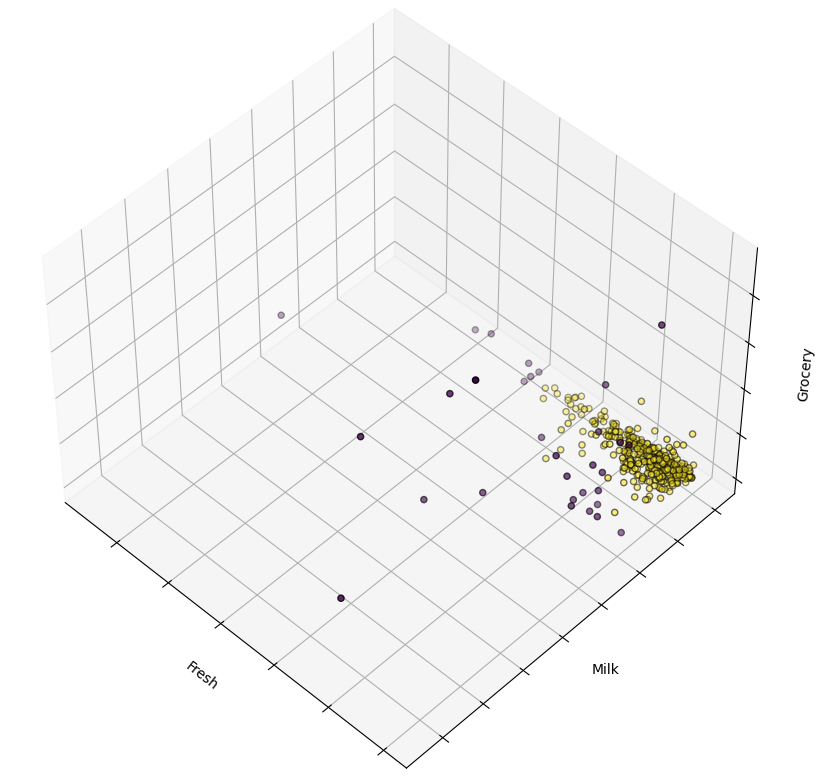

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Milk, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')


In [25]:
# creating df of only the anomalies

anomalies = df.loc[df['labels'] == -1]

In [26]:
anomalies.sample(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels
216,2,1,2532,16599,36486,179,13308,674,0.393233,0.225263,0.022551,-1
23,2,3,26373,36423,22019,5154,4337,16523,0.237300,0.495187,0.235136,-1
254,1,1,10379,17972,4748,4686,1547,3265,0.051144,0.243958,0.092521,-1
211,2,1,12119,28326,39694,4736,19410,2870,0.427811,0.384938,0.108036,-1
125,1,3,76237,3473,7102,16538,778,918,0.076517,0.046539,0.679762,-1
145,2,3,22039,8384,34792,42,12591,4430,0.374974,0.113408,0.196490,-1
86,2,3,22925,73498,32114,987,20070,903,0.346109,1.000000,0.204391,-1
45,2,3,5181,22044,21531,1740,7353,4985,0.232040,0.299402,0.046171,-1
85,2,3,16117,46197,92780,1026,40827,2944,1.000000,0.628270,0.143685,-1
103,1,3,56082,3504,8906,18028,1480,2498,0.095961,0.046962,0.500045,-1


## Now with the curriculum logs

In [27]:
# acquiring data

cur_df = pd.read_csv('curriculum_logs.csv')

In [28]:
cur_df.sample(5)

,Unnamed: 0,date,time,path,user_id,cohort_id,ip
254986,254986,2019-04-29,11:16:56,9.2_Detect_through_Probability,351,NaN,97.105.19.58
733892,733892,2020-11-17,10:28:00,search/search_index.json,705,61.0,136.50.70.48
548087,548087,2020-05-19,23:31:58,appendix/capstone-workbook,275,26.0,76.204.31.63
164016,164016,2018-12-03,16:20:48,javascript-i/google-maps-api,302,27.0,97.105.19.58
255349,255349,2019-04-29,15:24:01,mysql/clauses/where,329,29.0,97.105.19.58
